# Introduction of dataset

In [1]:
import os, sys
import numpy as np
import h5py
import sigpy as sp
import matplotlib.pyplot as plt
import pathlib
plt.rcParams["figure.figsize"] = (10,10)

import skimage
from fastmri.evaluate import ssim

import sigpy.plot as pl
from torch.utils.data import DataLoader, Dataset
import torch

In [2]:
# location of the dset : /mnt/dense/kanghyun/summer_dset
# There are 4 datasets (different contrast or anatomy)
print('Datasets: ',os.listdir('/mnt/dense/kanghyun/summer_dset'))
print('Inside Coronal-PD directory: ',os.listdir('/mnt/dense/kanghyun/summer_dset/div_coronal_pd'))
print('Inside Train directory: ',os.listdir('/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Train'))

basedir = '/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Train' # make this as base directory and move on

Datasets:  ['div_coronal_pd', 'div_coronal_pd_fs', 'div_axial_t2', 'div_sagittal_t2']
Inside Coronal-PD directory:  ['Test', 'Train', 'Val']
Inside Train directory:  ['rawdata_14.h5', 'rawdata_10.h5', 'rawdata_11.h5', 'rawdata_15.h5', 'rawdata_5.h5', 'rawdata_1.h5', 'rawdata_18.h5', 'rawdata_2.h5', 'rawdata_16.h5', 'rawdata_8.h5', 'rawdata_17.h5', 'rawdata_9.h5', 'rawdata_13.h5']


In [3]:
# Reading h5 file
# h5 file is a format to store a large size array, which can not be accessed fully with RAM
with h5py.File(os.path.join(basedir, 'rawdata_14.h5'),'r') as hr:
    print(list(hr.keys())) # What is inside the h5 file
    kspace = hr['kspace'][:] # saving the array to numpy (RAM)
    sens = hr['sens'][:]

print(kspace.shape, sens.shape) # order (nslices, nCoils, nX, nY)
# Note that nX is much bigger than nY (because for Cartesian, sampling in nX doesn't affect overall scan time)
# Scan time for the dataset : TR x nY. TR affects image contrast (small TR -> T1 weighting, large TR -> PD / T2 weighting)

['kspace', 'sens']
(35, 15, 577, 332) (35, 15, 577, 332)


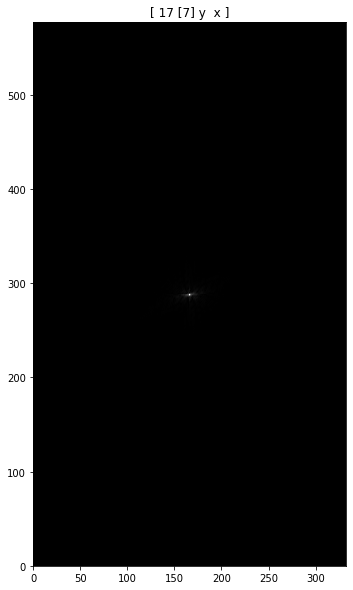

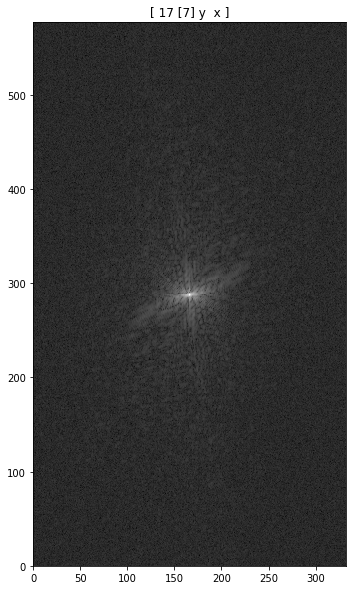

In [4]:
# Now let's look at the kspace

pl.ImagePlot(kspace) # Visualization of kspace in original space
pl.ImagePlot(kspace**0.2) # Visualization of kspace in approx. log scale (much better to visualize)

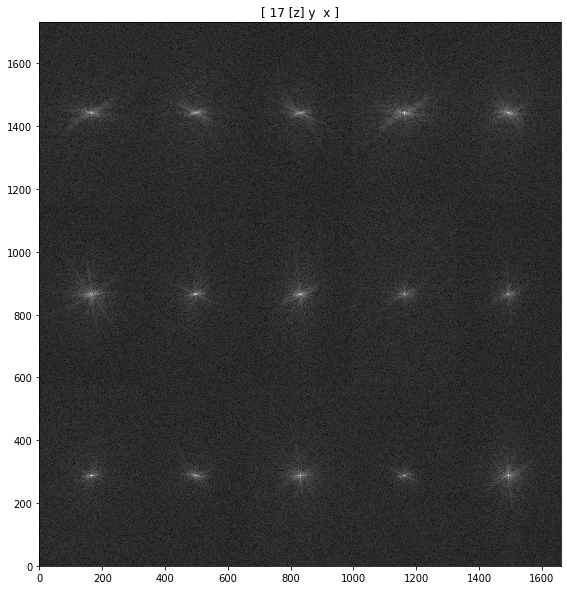

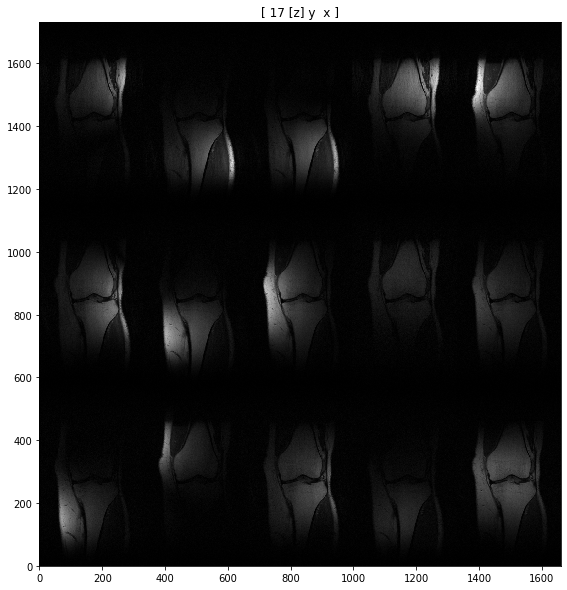

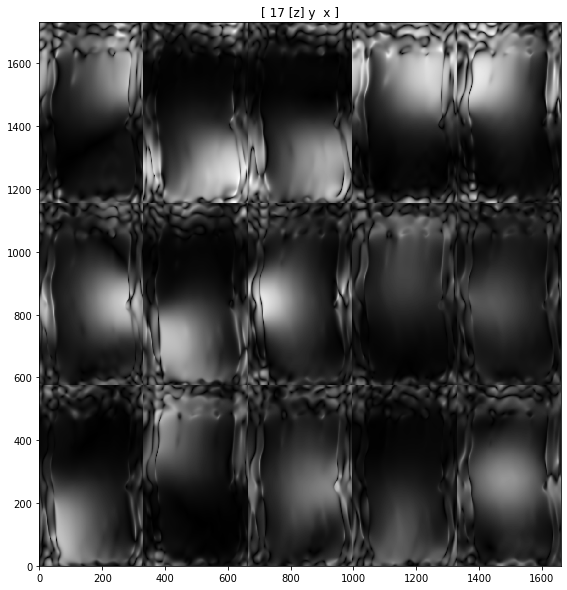

In [5]:
pl.ImagePlot(kspace**0.2, z=1) # Let's look at multi-coil kspace, z=1 means visualizing grid on the axis =1
# ith kspace corresponds to fft(true_image * coil_sensitivity_i) 

im_coil = sp.ifft(kspace, axes=(-1,-2)) # Let's ifft kspace to get coil image

pl.ImagePlot(im_coil, z=1) # Here now you can see each images correspond to true_image * coil_sensitivity
pl.ImagePlot(sens, z=1) # Look at the sensitivity map

RSS combined (35, 577, 332)


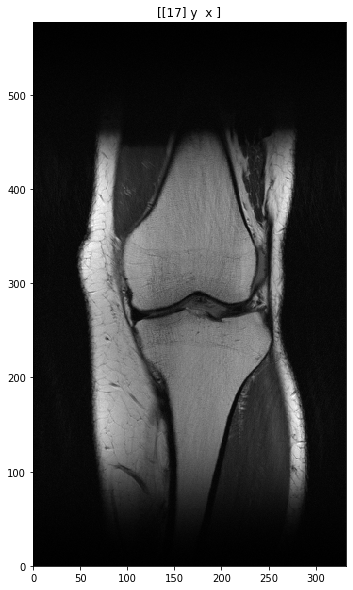

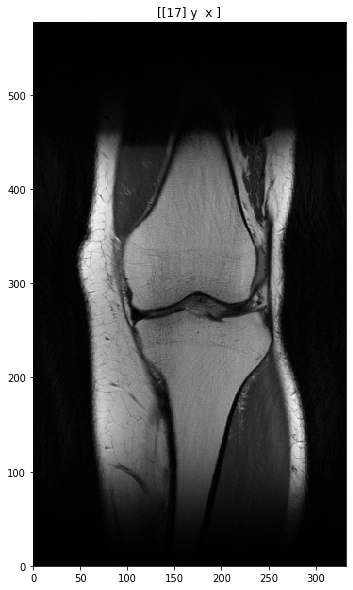

In [6]:
# there are mainly two ways to combine the multi-coil images
# 1. coils are designed to be symetrically distributed around the object, so usually root-sum-of squares can get sufficient estimates

im_rss = np.sqrt((im_coil * np.conj(im_coil)).sum(axis=1)) # np.conj because MR images are complex
print('RSS combined', im_rss.shape)
pl.ImagePlot(im_rss) 

# 2. Coil sensitivity maps can be scanned or estimated (i.e. ESPIRIT, JSENSE, etc.) and used to combine  

im_sense = np.sum(im_coil * np.conj(sens), axis=1)
pl.ImagePlot(im_sense) 

# (optional) Refer to https://users.fmrib.ox.ac.uk/~mchiew/docs/SENSE_tutorial.html, It's in MATLAB but covers SENSE reconstruction, gfactor maps

# Simulation of Undersampled acquisition

(1, 1, 1, 332)


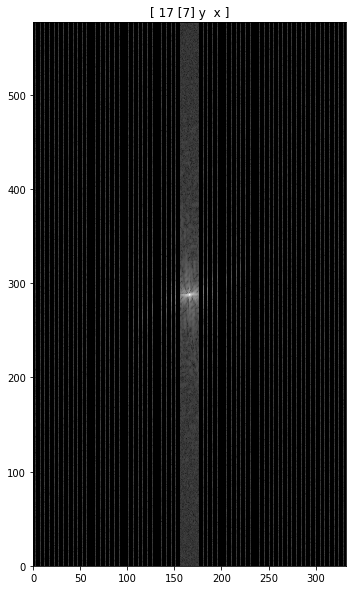

In [7]:
from fastmri.data import subsample, transforms

R = 4
mask_func = subsample.EquispacedMaskFunc(
                            center_fractions=[0.06],
                            accelerations=[R]) # This function generates an equispaced sampling mask generator
# help(subsample.EquispacedMaskFunc) # This is the description (uncomment this)

mask = mask_func(list(kspace.shape) + [1])[...,0] # trick because undersampling is in axis -1
mask = mask.numpy()
print(mask.shape)

kspace_us = kspace * mask 
pl.ImagePlot(kspace_us ** 0.2)

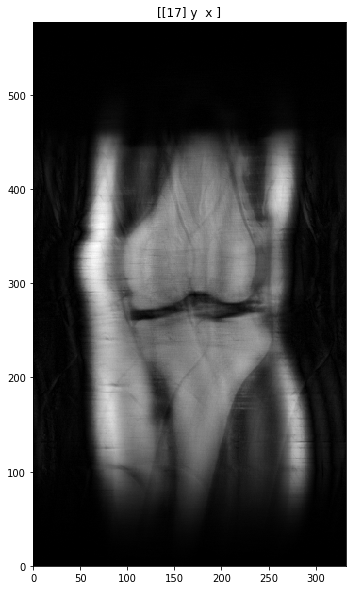

In [8]:
im_us_coil = sp.ifft(kspace_us, axes=(-1,-2)) # Let's try to reconstruct with the same process
im_us_sense = np.sum(im_us_coil * np.conj(sens), axis=1)

pl.ImagePlot(im_us_sense) # Now we get a weird aliased image

# Typically SENSE/GRAPPA (Parallel Imaging) method can recover x2 accelerations, 
# Parallel Imaging + Compressed Sensing (PI-CS) can recover x2-4 accelerations
# Deep Learning can recover up to x4-6 accelerations
# The final objective will be (im_us_sense + kspace_us + sensivitiy) ==> Deep Learning Recon ==> im_sense


In [9]:
# For demonstration, let's look at PI-CS reconstruction method
# PI-CS method performs better with random-sampling so the result may be worse than it actually is
# Refer to https://github.com/mikgroup/sigpy-mri-tutorial/blob/master/03-building-an-l1-wavelet-recon-app.ipynb

PI-CS solves the following minimization problem:
$$\min_x \frac{1}{2} \| \underbrace{P F S }_{A} x - y \|_2^2 + \lambda \|W x \|_1$$
Where P is the sampling operator, F is the Fourier Transform operator, S is the sensitivity map operator, W is the wavelet transform operator


In [10]:
from sigpy.mri.app import L1WaveletRecon

y = kspace_us[17] # select 17th slice
mps = sens[17]

img = L1WaveletRecon(y, mps, lamda = 0.05).run() # lamda is the regularizaition

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

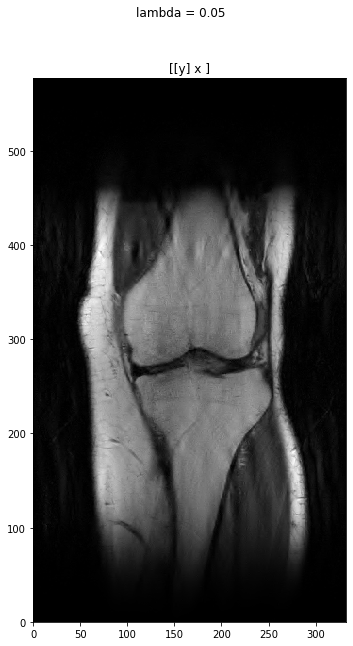

In [11]:
lambda_ = 0.05
pl.ImagePlot(img, title = f'lambda = {lambda_}') # This is the reconstructed result

In [ ]:
# Task to do : 1. How does the reconstructed image looks for different lambda values
# 2. What is the quantitative score (nRMSE, SSIM) for the above image? Can you calculate mean + std for the score for the images in Test 
# Please try this demo for other datasets and ask questions on Notion

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

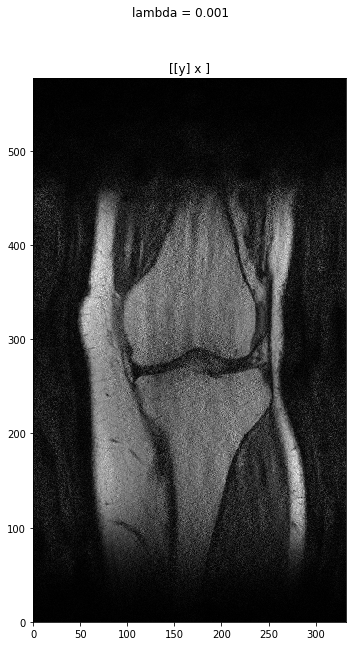

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

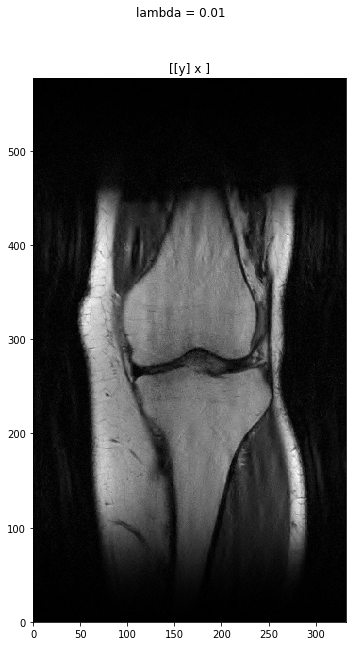

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

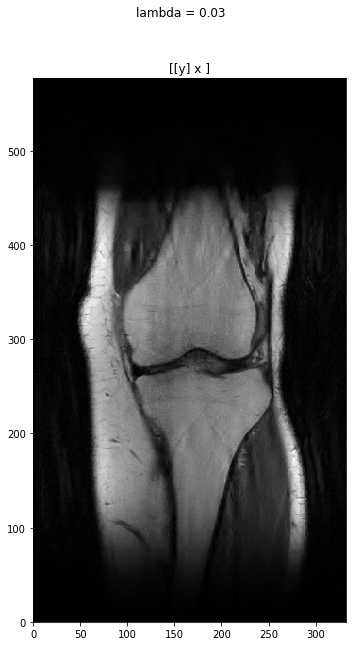

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

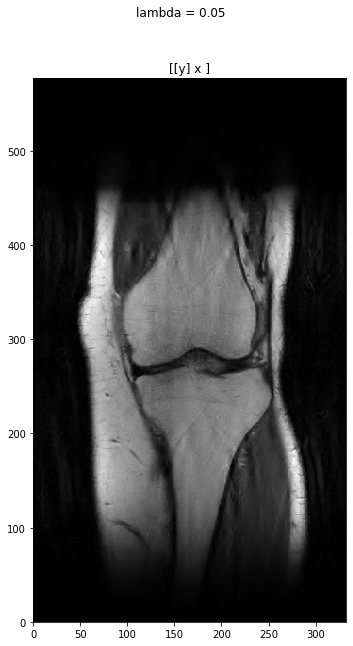

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

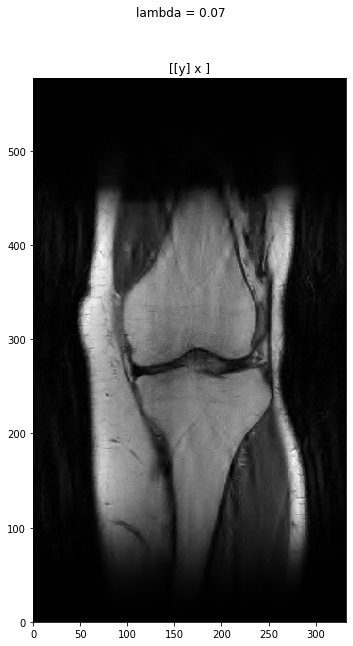

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

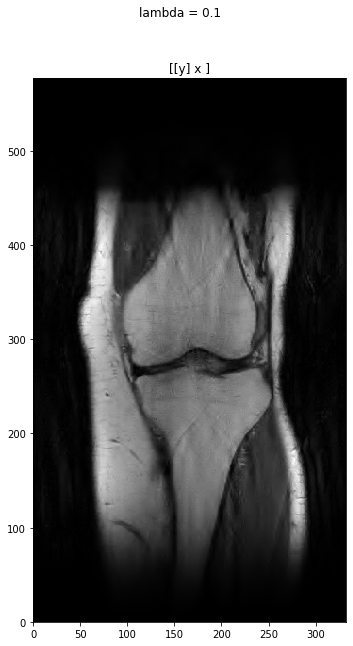

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

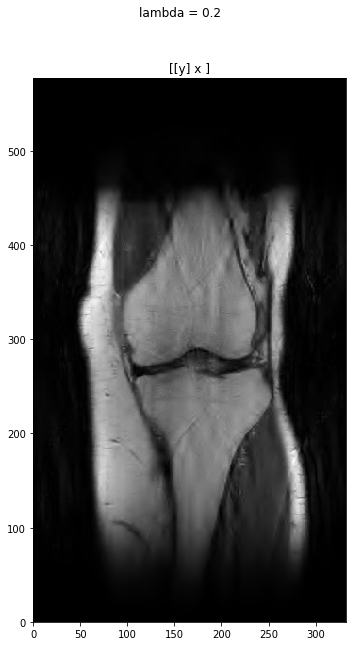

In [52]:
# Task 1
lambdas = [0.001, 0.01, 0.03, 0.05, 0.07, 0.1, 0.2]
for lambda_ in lambdas:
    img = L1WaveletRecon(y, mps, lamda = lambda_).run() # lamda is the regularizaition
    pl.ImagePlot(img, title = f'lambda = {lambda_}') # This is the reconstructed result

When $\lambda$ is too low, the image looks noisy. When $\lambda$ is too high, the image looks overly smooth and seems to miss out on textural details.

In [20]:
# task 2 ssim and nrmse for slice 17
# convert complex nums to magnitude
im_true = np.absolute(im_sense)[17]
im_us = np.absolute(img)
im_true = np.expand_dims(im_true, axis = 0)
im_us = np.expand_dims(im_us, axis = 0)

print (f'SSIM: {ssim(im_true, im_us)}')
print (f'nRMSE: {skimage.metrics.normalized_root_mse(im_true, im_us)}')

SSIM: 0.8356309970385644
nRMSE: 0.09242827878186612


In [21]:
# task 2:
# use custom dataset class from 2_dataloader.ipynb
# change center_fractions to 0.06 and accelerations to 4
# to match current problem

class MRIDataset(Dataset):
    def __init__(self, root, center_fractions=[0.06], accelerations=[4]):
        self.examples = []
        Files = list(pathlib.Path(root).glob('*.h5'))
        for fname in Files:
            h5file = h5py.File(fname, 'r')
            kspace = h5file['kspace']
            nsl = kspace.shape[0] # get number of slices
            self.examples += [(fname, sl) for sl in range(nsl)]
        
        self.mask_func = subsample.EquispacedMaskFunc(center_fractions=center_fractions, accelerations=accelerations)
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        fname, sl = self.examples[idx]
        with h5py.File(fname, 'r') as hr:
            kspace, sens = hr['kspace'][sl], hr['sens'][sl]
        kspace = kspace / 10 # divide by 10 because the values are too large
        im_coil = sp.ifft(kspace, axes=[1, 2])
        im_true = np.sum(im_coil * np.conj(sens), axis=0) # im_true is the fully sampled reconned image
        
        mask = self.mask_func(list(im_true.shape) + [1])[...,0]                              
        mask = np.expand_dims(mask, axis=0)
        masked_kspace = kspace * mask # undersampled kspace
        mask = np.expand_dims(mask, axis=-1)
        
        # Now transform everything to tensor. The complex kspace will be changed to [real, imag] in the final axis
        masked_kspace = transforms.to_tensor(masked_kspace) 
        mask = transforms.to_tensor(mask)
        sens = transforms.to_tensor(sens)
        im_true = np.expand_dims(im_true, axis=0)
        im_true = transforms.to_tensor(im_true)
                        
        return masked_kspace, mask.byte(), sens, im_true

In [25]:
# Task 2
dataset = 'Test'
basedir = f'/mnt/dense/kanghyun/summer_dset/div_coronal_pd/{dataset}'
dset = MRIDataset(basedir)

ssims = np.zeros(len(dset))
nrmses = np.zeros(len(dset))

for iidx, (kspace_us, _, sens, im_true) in enumerate(dset):
    # make ndarray for wavelet 
    kspace_us = transforms.tensor_to_complex_np(kspace_us)
    sens = transforms.tensor_to_complex_np(sens)
    im_true = transforms.tensor_to_complex_np(im_true)
    
    # reconstruct undersampled 2D img w wavelet
    im_us = L1WaveletRecon(
        kspace_us, 
        sens, 
        lamda = 0.05
    ).run()
    
    
    # convert complex nums to magnitude
    im_true = np.absolute(im_true)
    im_us = np.absolute(im_us)
    im_us = np.expand_dims(im_us, axis = 0) # expand bc need 3 dims

    ssims[iidx] = ssim(im_true, im_us)
    nrmses[iidx] = skimage.metrics.normalized_root_mse(im_true, im_us)
    
    print (f'SSIM {iidx}: {ssim(im_true, im_us)}')
    print (f'nRMSE {iidx}: {skimage.metrics.normalized_root_mse(im_true, im_us)}')

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 0: 0.8796240816778736
nRMSE 0: 0.21698291091492397


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 1: 0.7548506890741288
nRMSE 1: 0.17230253988325908


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 2: 0.713847317965892
nRMSE 2: 0.1648435402790997


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 3: 0.6578100354046639
nRMSE 3: 0.15033631272091433


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 4: 0.6562429718553086
nRMSE 4: 0.13567827723599868


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 5: 0.6495400363219834
nRMSE 5: 0.1329698975473418


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 6: 0.6556602586153425
nRMSE 6: 0.132171743660806


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 7: 0.6950862433743186
nRMSE 7: 0.1357622614650697


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 8: 0.7110735269947835
nRMSE 8: 0.12804843381726552


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 9: 0.7389803171370538
nRMSE 9: 0.14328362925917423


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 10: 0.7250058652490848
nRMSE 10: 0.13087324903053654


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 11: 0.7484355327831768
nRMSE 11: 0.13733693887663156


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 12: 0.7240884583453738
nRMSE 12: 0.15574272444288786


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 13: 0.7336267738688754
nRMSE 13: 0.1256029320176016


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 14: 0.733747980582375
nRMSE 14: 0.12535255146352545


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 15: 0.7294739630285253
nRMSE 15: 0.1303762656869323


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 16: 0.7392597527447182
nRMSE 16: 0.12963556097459109


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 17: 0.7437193570751539
nRMSE 17: 0.12580824557505693


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 18: 0.7545272929199686
nRMSE 18: 0.12780822737042924


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 19: 0.7280705514905167
nRMSE 19: 0.13166536435208273


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 20: 0.7387063337651188
nRMSE 20: 0.1352137954754469


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 21: 0.7675334327149705
nRMSE 21: 0.14057555627445265


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 22: 0.7984447321051368
nRMSE 22: 0.13404615826754868


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 23: 0.7894725932868123
nRMSE 23: 0.14764695421194504


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 24: 0.8065242860861994
nRMSE 24: 0.1335107614798933


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 25: 0.8255796380193847
nRMSE 25: 0.13212443272154967


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 26: 0.8238292274456774
nRMSE 26: 0.1489966849673053


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 27: 0.8273569663534209
nRMSE 27: 0.1542499145657878


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 28: 0.865753523371214
nRMSE 28: 0.1420780522406479


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 29: 0.8488314340422843
nRMSE 29: 0.16777982736697597


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 30: 0.8689595881116091
nRMSE 30: 0.16392086347705148


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 31: 0.9007200107357778
nRMSE 31: 0.14776345772917876


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 32: 0.8945728054109231
nRMSE 32: 0.1550648280741537


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 33: 0.8960801157359694
nRMSE 33: 0.1447753142294096


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 34: 0.8966088182031925
nRMSE 34: 0.13486654402319212


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 35: 0.870959133237962
nRMSE 35: 0.12852152442630727


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 36: 0.8435836401372879
nRMSE 36: 0.09229270703794862


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 37: 0.848118788636398
nRMSE 37: 0.08882352171826424


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 38: 0.8585366881833759
nRMSE 38: 0.0878023449281373


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 39: 0.8298365160273391
nRMSE 39: 0.09384946079034612


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 40: 0.824199210171668
nRMSE 40: 0.09246489816862227


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 41: 0.8062044989164833
nRMSE 41: 0.09211296273098239


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 42: 0.8019848602679129
nRMSE 42: 0.09409999506731698


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 43: 0.8182852309759658
nRMSE 43: 0.10018513655421377


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 44: 0.8311569170802828
nRMSE 44: 0.09562555546477158


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 45: 0.8291230008480903
nRMSE 45: 0.0967854341922511


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 46: 0.8303882091965245
nRMSE 46: 0.09635303466755764


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 47: 0.8363161266722148
nRMSE 47: 0.09465345740231874


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 48: 0.8408036376327881
nRMSE 48: 0.09357421220839982


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 49: 0.843468398175234
nRMSE 49: 0.09803882710954358


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 50: 0.8432186813791132
nRMSE 50: 0.1084321342546138


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 51: 0.8742993294861005
nRMSE 51: 0.0981360972576556


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 52: 0.8727175450213925
nRMSE 52: 0.10054072386077871


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 53: 0.8627027925443691
nRMSE 53: 0.11030230570474707


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 54: 0.8862098104350778
nRMSE 54: 0.10121139258204279


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 55: 0.8989284945897236
nRMSE 55: 0.10134370793773288


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 56: 0.8900585165621079
nRMSE 56: 0.10376298333839427


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 57: 0.8876834503186493
nRMSE 57: 0.10547428168696263


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 58: 0.8699485503667453
nRMSE 58: 0.10642509928135906


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 59: 0.879562371118808
nRMSE 59: 0.10496688658733104


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 60: 0.8932852182104546
nRMSE 60: 0.10091953189313307


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 61: 0.885551701512332
nRMSE 61: 0.11491716390230526


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 62: 0.8857503545609231
nRMSE 62: 0.11306841944478827


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 63: 0.8747878766675937
nRMSE 63: 0.11175862457432509


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 64: 0.8788485188949073
nRMSE 64: 0.10603006927323194


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 65: 0.8674501266102219
nRMSE 65: 0.10234555850834845


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 66: 0.8450622295678998
nRMSE 66: 0.1083828164325734


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 67: 0.8413059838088808
nRMSE 67: 0.11909684778438341


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 68: 0.8737111607157383
nRMSE 68: 0.09750632390207421


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 69: 0.864387804903973
nRMSE 69: 0.09690579368676366


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 70: 0.8590909179275821
nRMSE 70: 0.09046655674342059


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 71: 0.8419389675341188
nRMSE 71: 0.09581604726838976


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 72: 0.18696937107917908
nRMSE 72: 0.6966122158496684


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 73: 0.8516503835643545
nRMSE 73: 0.28269038850350653


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 74: 0.7384300626741617
nRMSE 74: 0.18316737340939707


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 75: 0.743456770919579
nRMSE 75: 0.17205911598791868


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 76: 0.7496958513995171
nRMSE 76: 0.15606586502173636


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 77: 0.7379012184800932
nRMSE 77: 0.1518889678352979


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 78: 0.7545522846876199
nRMSE 78: 0.1502486045745299


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 79: 0.7479151174843319
nRMSE 79: 0.14768886123074979


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 80: 0.7390798862972427
nRMSE 80: 0.14222596349647879


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 81: 0.7190489695202771
nRMSE 81: 0.1568715547889317


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 82: 0.7594877439350628
nRMSE 82: 0.13685910546488683


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 83: 0.7706735479353729
nRMSE 83: 0.14153004631678556


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 84: 0.7706514782826307
nRMSE 84: 0.1342647843228516


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 85: 0.7643747663518455
nRMSE 85: 0.14043813927976975


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 86: 0.7776849883931573
nRMSE 86: 0.13347912438929627


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 87: 0.7867136382989579
nRMSE 87: 0.12584414070770875


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 88: 0.7962308735365171
nRMSE 88: 0.13048632969713123


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 89: 0.7859928127823981
nRMSE 89: 0.1310220347074871


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 90: 0.7887591340834433
nRMSE 90: 0.1382204096006088


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 91: 0.8113548949330859
nRMSE 91: 0.13505207703013286


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 92: 0.8135419437413384
nRMSE 92: 0.13478299305145441


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 93: 0.8189990633254605
nRMSE 93: 0.12951658905727034


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 94: 0.8338203908010453
nRMSE 94: 0.13874013750019734


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 95: 0.8029721183152237
nRMSE 95: 0.1442088755377067


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 96: 0.7996570739456698
nRMSE 96: 0.14622080515877164


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 97: 0.7905128382074748
nRMSE 97: 0.13901243928809098


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 98: 0.7750399809359879
nRMSE 98: 0.1448833717890502


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 99: 0.7539573045748825
nRMSE 99: 0.14753262032159398


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 100: 0.7679736591494358
nRMSE 100: 0.15324426882742678


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 101: 0.7748430768357091
nRMSE 101: 0.15584228064592098


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 102: 0.7931848559319385
nRMSE 102: 0.14442976597710447


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 103: 0.7892411603655731
nRMSE 103: 0.1512710862846079


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 104: 0.8167389312463145
nRMSE 104: 0.14522934777887342


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 105: 0.8064222138685462
nRMSE 105: 0.1576490448935892


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 106: 0.8248245654449615
nRMSE 106: 0.1578083877111359


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 107: 0.8468636146473787
nRMSE 107: 0.14828858004747725


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 108: 0.8573276910898905
nRMSE 108: 0.15453852245678176


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 109: 0.870636618403635
nRMSE 109: 0.14280776871397394


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 110: 0.8620929567184936
nRMSE 110: 0.144975492721069


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 111: 0.890190917109464
nRMSE 111: 0.12710031695932772


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 112: 0.890681224358572
nRMSE 112: 0.1272606040844362


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 113: 0.3509762730302421
nRMSE 113: 0.6798306005356664


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 114: 0.7754175156131815
nRMSE 114: 0.18704001475752569


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 115: 0.6994565650321412
nRMSE 115: 0.15144180363870433


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 116: 0.6827829057382299
nRMSE 116: 0.13770803580637833


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 117: 0.6796514400784681
nRMSE 117: 0.12515415327196427


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 118: 0.6938940782843623
nRMSE 118: 0.11651640674455838


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 119: 0.6986965545352933
nRMSE 119: 0.12133307593041116


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 120: 0.710407445882912
nRMSE 120: 0.12293330347434384


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 121: 0.7318169230332954
nRMSE 121: 0.12730581587775391


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 122: 0.7503358447920636
nRMSE 122: 0.11917710835894814


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 123: 0.7510481301128403
nRMSE 123: 0.12533910825346956


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 124: 0.768365925215765
nRMSE 124: 0.12036366404058785


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 125: 0.7842144024489164
nRMSE 125: 0.12074673138216334


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 126: 0.7913689710629442
nRMSE 126: 0.11351769099192306


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 127: 0.7945724167839168
nRMSE 127: 0.11344209677697557


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 128: 0.7758057841552896
nRMSE 128: 0.12864114839173454


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 129: 0.7904231627593452
nRMSE 129: 0.12358594895735708


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 130: 0.7849818781576237
nRMSE 130: 0.12866726100200357


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 131: 0.7767143594800938
nRMSE 131: 0.12854701951660247


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 132: 0.7879488019479289
nRMSE 132: 0.11882057600236962


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 133: 0.7848342528971433
nRMSE 133: 0.12728179385036742


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 134: 0.8029075920428929
nRMSE 134: 0.12323635841359538


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 135: 0.7838877633414558
nRMSE 135: 0.13451243642442318


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 136: 0.8095055700647816
nRMSE 136: 0.11880769434728997


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 137: 0.7890154895564234
nRMSE 137: 0.12776363677780214


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 138: 0.8155281956482403
nRMSE 138: 0.12487977835145783


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 139: 0.8256595817355573
nRMSE 139: 0.12676498726197552


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 140: 0.8057671438311718
nRMSE 140: 0.13913641832664497


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 141: 0.8300401903689544
nRMSE 141: 0.13141687966757384


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 142: 0.8486020938965848
nRMSE 142: 0.12849306135458763


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 143: 0.8607074603178523
nRMSE 143: 0.12223506553721836


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 144: 0.8539997447796724
nRMSE 144: 0.1339767965679197


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 145: 0.874922617223069
nRMSE 145: 0.11515660273481451


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 146: 0.8570972766581612
nRMSE 146: 0.12921057665992974


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 147: 0.8615802797119432
nRMSE 147: 0.11551288904231335


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SSIM 148: 0.8727199540299369
nRMSE 148: 0.10791437757259824
mean ssim: 0.7954826197899165
std ssim: 0.08676424889467943
mean nrmse: 0.13756145307163548
std nrmse: 0.13756145307163548


In [27]:
print(f'mean ssim: {np.mean(ssims)}')
print(f'std ssim: {np.std(ssims)}')
print(f'mean nrmse: {np.mean(nrmses)}')
print(f'std nrmse: {np.std(nrmses)}')

mean ssim: 0.7954826197899165
std ssim: 0.08676424889467943
mean nrmse: 0.13756145307163548
std nrmse: 0.06900692316587283


The SSIM is $0.7955 \pm 0.0867$; the nRMSE is $0.1376 \pm 0.0690$ for Wavelet-based reconstruction.

In [34]:
# for other datasets, not as verbose and put into a function
# Task 2

dataset_names = ['div_coronal_pd', 'div_coronal_pd_fs', 'div_axial_t2', 'div_sagittal_t2',]
dataset_types = ['Train', 'Test', 'Val',]
basedirs = [
    f'/mnt/dense/kanghyun/summer_dset/{dataset_name}/{dataset_type}'
    for dataset_name in dataset_names
    for dataset_type in dataset_types
]
basedirs

['/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Train',
 '/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test',
 '/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Val',
 '/mnt/dense/kanghyun/summer_dset/div_coronal_pd_fs/Train',
 '/mnt/dense/kanghyun/summer_dset/div_coronal_pd_fs/Test',
 '/mnt/dense/kanghyun/summer_dset/div_coronal_pd_fs/Val',
 '/mnt/dense/kanghyun/summer_dset/div_axial_t2/Train',
 '/mnt/dense/kanghyun/summer_dset/div_axial_t2/Test',
 '/mnt/dense/kanghyun/summer_dset/div_axial_t2/Val',
 '/mnt/dense/kanghyun/summer_dset/div_sagittal_t2/Train',
 '/mnt/dense/kanghyun/summer_dset/div_sagittal_t2/Test',
 '/mnt/dense/kanghyun/summer_dset/div_sagittal_t2/Val']

In [1]:
import csv

def metrics_wavelet(basedir):
    dset = MRIDataset(basedir)

    ssims = np.zeros(len(dset))
    nrmses = np.zeros(len(dset))

    for iidx, (kspace_us, _, sens, im_true) in enumerate(dset):
        # make ndarray for wavelet 
        kspace_us = transforms.tensor_to_complex_np(kspace_us)
        sens = transforms.tensor_to_complex_np(sens)
        im_true = transforms.tensor_to_complex_np(im_true)

        # reconstruct undersampled 2D img w wavelet
        im_us = L1WaveletRecon(
            kspace_us, 
            sens, 
            lamda = 0.05
        ).run()

        # convert complex nums to magnitude
        im_true = np.absolute(im_true)
        im_us = np.absolute(im_us)
        im_us = np.expand_dims(im_us, axis = 0) # expand bc need 3 dims

        ssims[iidx] = ssim(im_true, im_us)
        nrmses[iidx] = skimage.metrics.normalized_root_mse(im_true, im_us)

    print(f'dataset: {basedir}')
    print(f'mean ssim: {np.mean(ssims)}')
    print(f'std ssim: {np.std(ssims)}')
    print(f'mean nrmse: {np.mean(nrmses)}')
    print(f'std nrmse: {np.std(nrmses)}')
    

    with open('metrics_wavelet.csv', 'a') as file:
        writer = csv.writer(file)
        writer.writerow([basedir, np.mean(ssims), np.std(ssims), np.mean(nrmses), np.std(nrmses)])
    file.close()

    
with open('metrics_wavelet.csv', 'a') as file:
    writer = csv.writer(file)
    writer.writerow(["Dataset", "SSIM mean", "SSIM std", "nRMSE mean", "nRMSE std"])
file.close()

for basedir in basedirs:
    metrics_wavelet(basedir)